In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from network.mlp import MLP

In [4]:
###########################################
#######     CHANGE TASK ID HERE     #######
###########################################
# id in the tasks considered by Luo et al.
task_id = 4    

#############################################
#######    CHANGE PARAMETERS HERE    ########
#############################################
# number of trajectories stitched together
n_trajs = 20    

## Prepare Data and Network

### Load traj data and Visualise the data trajectories

In [5]:
device = 'cuda'
trajs = np.load('all_traj.npy')
trajs = torch.tensor(trajs).to(device).reshape(-1, trajs.shape[-1]*trajs.shape[-2])
print('Data shape:', trajs.shape)

Data shape: torch.Size([1005000, 128])


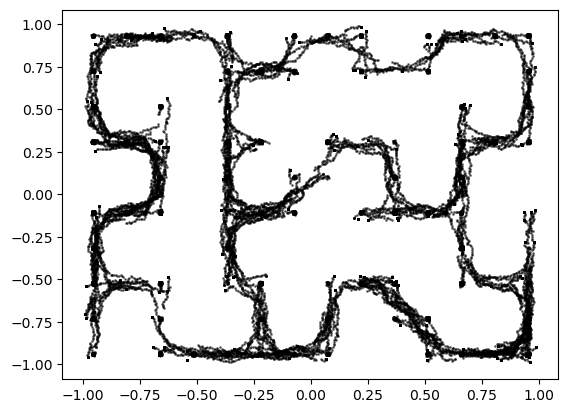

In [7]:
# visualise the data trajectories
for i in range(0, trajs.shape[0], 2000):
    traj = trajs[i].reshape(-1, 2)
    plt.scatter(traj[:, 0].cpu(), traj[:, 1].cpu(), s=1, c='k', alpha=0.5)

dim = trajs.shape[-1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Pretrained network

In [8]:
ema_net = MLP(dim, device, data_sigma=0.6, num_layers=5, num_hid=512).to(device)
ema_net.load_state_dict(torch.load("traj_net.pt"))

<All keys matched successfully>

## Prepare task info, Define Hyperparameters

### Define task info

In [9]:
# task information taken from Luo et al.

tasks = [
[(1, 1), (10, 14)], # checked
[(1, 14), (10, 1)],
[(8, 14), (1, 1)],
[(8, 3), (5, 12)],
[(5, 9), (3, 8)],
]

A, B = tasks[task_id]
A = torch.tensor([A[1], A[0]])
B = torch.tensor([B[1], B[0]])
A = A*4 - 4
B = B*4 - 4

mins = torch.tensor([-1.26, -1.18])
maxs = torch.tensor([53.24, 37.29])

# Normalisation taken from Luo et al.
def unnormalize(x, max, min, eps=1e-4):
    '''
        x : [ -1, 1 ]
    '''
    if x.max() > 1 + eps or x.min() < -1 - eps:
        # print(f'[ datasets/mujoco ] Warning: sample out of range | ({x.min():.4f}, {x.max():.4f})')
        x = np.clip(x, -1, 1)

    ## [ -1, 1 ] --> [ 0, 1 ]
    x = (x + 1) / 2.

    return x * (max - min) + min
def normalize(x, maxs, mins):
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins)
    ## [ -1, 1 ]
    x = 2 * x - 1
    return x

A = normalize(A, maxs, mins).to(device)
B = normalize(B, maxs, mins).to(device)
path_length = 64  

In [19]:
print(A, B)

tensor([ 0.2206, -0.1068], device='cuda:0') tensor([ 0.0738, -0.5227], device='cuda:0')


### Define reward functions

In [10]:
# define internediate rewards for PT control
def intermediate_reward1(x0_hat, n_trajs):
    ### reward to ensure the continuity of the trajectory
    x0_hat = x0_hat.reshape(-1, n_trajs, path_length, 2)
    x_next_start = x0_hat[:, 1:, 0, :]
    x_last_end = x0_hat[:, :-1, -1, :]
    c = 1e-5
    d2 = (x_next_start - x_last_end)**2 + c
    
    r = -(d2 +  10 * d2**0.5).sum(-1) * 100
    r = r.sum(-1) 
    return r

def intermediate_reward2(x0_hat, n_trajs):
    ### reward to ensure the trajectory starts and ends at the correct points
    x0_hat = x0_hat.reshape(-1, n_trajs, path_length, 2)
    x_first_start = x0_hat[:, 0, 0, :]
    x_last_end = x0_hat[:, -1, -1, :]
    c = 1e-5
    d21 = (x_first_start - A)**2 + c
    r = -(d21 + 10*d21**0.5).sum(-1) * 100 *  n_trajs
    d22 = (x_last_end - B)**2 + c
    r += -(d22 + 10*d22**0.5).sum(-1) * 100 * n_trajs
    return r

def intermediate_reward3(x0_hat, n_trajs):
    ### reward to ensure the trajectory does not go too far away from the original trajectory
    x0_hat = x0_hat.reshape(-1, n_trajs * path_length * 2)
    r =  (x0_hat.abs() > 5.0).any(-1).float() * -1e10
    return r

def reward(xt, n_trajs):
    r1 = intermediate_reward1(xt, n_trajs)
    r2 = intermediate_reward2(xt, n_trajs)
    r3 = intermediate_reward3(xt, n_trajs)
    return  r3 + r2 + r1 

### Define Denoising Schedule and Reward Coef

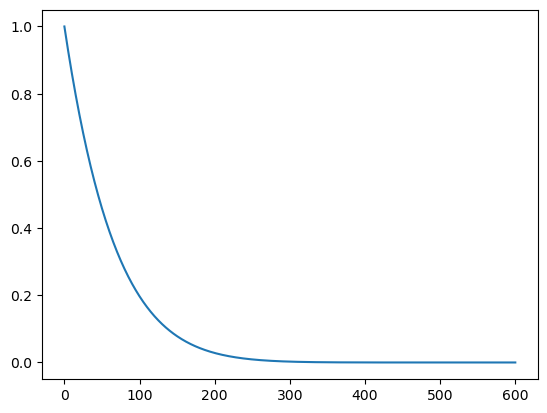

In [11]:
# EDM denoising schedule

tmax = 20
tmin = 1e-3
rho = 7
steps = 601

ts = tmin ** (1/rho) + np.arange(steps)/(steps-1) * (tmax ** (1/rho) - tmin ** (1/rho))
ts = ts ** rho



# define reward coef 
# This coefficient is used to scale the reward at different time steps
# to ensure the reward at the early time steps is close to 0
# and the reward at the later time steps is close to the final reward defined above
coef = np.geomspace(1e-4, 1, steps)[::-1]

coef_min = 1e-10
coef_max = 1
rho = 10
coef = coef_min ** (1/rho) + np.linspace(0, 1, steps)[::-1] * (coef_max ** (1/rho) - coef_min ** (1/rho) )
coef = coef ** rho
plt.plot(coef, label='Reward Coef')

## CREPE Control Body

In [12]:
# Gaussian Log Density
def log_norm_prob(x, mu, std):
    # expand std to match x shape
    std = std.expand(x.shape)
    return -0.5 * ((x - mu) / std).pow(2).sum(-1) - (std.log() + np.log(2*np.pi)/2).sum(-1)
def EM_solve_guidance(model, start_samples, n_trajs, all_levels):
    Rs = []
    with torch.no_grad():
        samples = start_samples
        Samples = [(ts[-1], len(ts)-1, start_samples.detach().cpu())]
        for i in tqdm(range(ts.shape[0]-1, 0, -1)):
            t = torch.ones(samples.shape[0], 1).to(samples.device) * ts[i]
            t_1 = torch.ones(samples.shape[0], 1).to(samples.device) * ts[i-1]

            Delta_t = (t - t_1).abs()
            x_hat = model(samples, t.flatten()) 
            std = torch.sqrt(2*Delta_t*t)
            score = - (samples - x_hat) / t ** 2 

            with torch.enable_grad():
                samples.requires_grad_()
                x0_hat = model(samples, t.flatten())
                r = reward(x0_hat, n_trajs).sum() * coef[i]
                guidance = torch.clip(torch.autograd.grad(r, samples)[0], -100, 100)
                samples = samples.detach()
                Rs.append(r.item())
            score = score + guidance

            dx = score * 2 * t * Delta_t  + std * torch.randn_like(samples)

            samples_new = samples + dx
            if i-1 in all_levels:
                Samples.append((ts[i-1], i-1, samples_new.detach().cpu()))

            samples = samples_new

        return Samples, Rs

In [13]:
# take all time steps as PT levels
gap = 1
assert (steps-1) % gap == 0, "Steps must be divisible by gap + 1"
all_levels = np.linspace(0, steps-1, (steps-1)//gap + 1)


### Run Initial Sample

In [14]:
bsz = 1
start_samples = torch.randn(bsz*n_trajs, dim, device=device) * ts[-1]
Samples, Rs = EM_solve_guidance(ema_net, start_samples, n_trajs, all_levels)

100%|██████████| 600/600 [00:02<00:00, 233.86it/s]


### Define the step size for local move

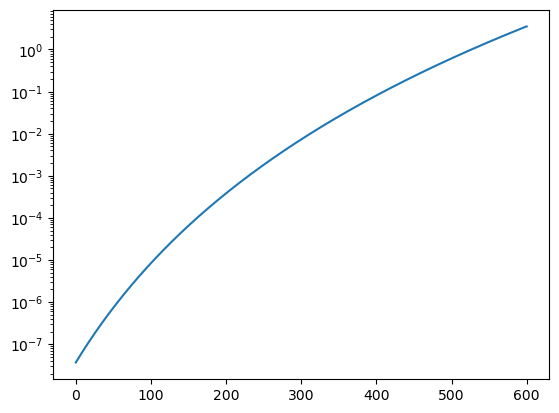

In [15]:
# let's define the step size for local move
idx = np.arange(steps)[::-1]
Delta_t = (ts[np.clip(idx+1, 0, len(ts)-1)] - ts[idx])
Delta_t[0] = Delta_t[1]  # first step is always the same
step_size = Delta_t*ts[::-1]
step_size = step_size[::-1]
plt.plot(step_size)
plt.yscale('log')

### Run PT starting from the initial sample



In [16]:
def APT_control(n_trajs, path_length, model_traj, Samples, step_size, gap):
    # we run two steps of APT
    # in the first step, we only exchange the samples at even indices
    # in the second step, we exchange the samples at odd indices
    time_steps = torch.from_numpy(np.array([s[0] for s in Samples])).to(device).float()
    samples = torch.stack([s[2] for s in Samples], dim=0).to(device).clone() # (time_steps, n_trajs, path_length*2)
    idx = np.array([s[1] for s in Samples])

    step_size = torch.from_numpy(step_size[idx]).float().to(samples.device)
    coef_all = torch.from_numpy(coef[idx]).float().to(samples.device)

    ALL_SAMPLES = []
    start_idx = 0
    MASKS1 = []
    MASKS2 = []
    NEW_SAMPLES = []
    for start_idx in [0, 1]:
        with torch.no_grad():
            # local move 
            local_move_time_steps = time_steps.reshape(-1, 1, 1).expand(-1, n_trajs, 1)
            with torch.enable_grad():
                samples = samples.clone().requires_grad_()
                x_hat = model_traj(samples.reshape(-1, samples.shape[-1]), local_move_time_steps.flatten()).reshape(samples.shape)
                guide = torch.clip(torch.autograd.grad(outputs=(reward(x_hat, n_trajs).flatten()*coef_all.flatten()).sum(), inputs=samples)[0], -1000, 1000)
            samples = samples.detach()
            score = - (samples - x_hat) / local_move_time_steps ** 2
            score = score.detach()
            guided_score = score + guide

            if guided_score.isnan().any():
                print('NaN detected in score, skipping step')
                continue
            dx = guided_score * step_size.reshape(-1, 1, 1)  + (step_size.reshape(-1, 1, 1)*2)**0.5 * torch.randn_like(samples)
            samples = samples + dx

            # # replace the first sample with the start sample
            samples[0] = torch.randn(samples[0].shape, device=device) * ts[-1]

            # swap
            x1 = samples[start_idx:-1:2]
            x0 = samples[start_idx+1::2]
            idx_1 = idx[start_idx:-1:2]
            idx_0 = idx[start_idx+1::2]

            w = 0

 
            # x1 to x0
            for step in range(gap):
                t_cur = torch.from_numpy(ts[idx_1 - step].reshape(-1, 1, 1)).float().to(x1.device).expand(-1, n_trajs, 1)
                t_next = torch.from_numpy(ts[idx_1 - 1 - step].reshape(-1, 1, 1)).float().to(x1.device).expand(-1, n_trajs, 1)

                coef_cur = torch.from_numpy(coef[idx_1 - step]).float().to(x1.device)
                coef_next = torch.from_numpy(coef[idx_1 - 1 - step]).float().to(x1.device)
                assert coef_cur.shape == (t_cur.shape[0], )
                assert coef_next.shape == (t_next.shape[0], )



                Delta_t = (t_cur - t_next).abs()

                x_hat = model_traj(x1.reshape(-1, x1.shape[-1]), t_cur.flatten()).reshape(-1, n_trajs, x1.shape[-1])
                std = torch.sqrt(2*Delta_t*t_cur)
                score = - (x1 - x_hat) / t_cur ** 2 

                with torch.enable_grad():
                    x1.requires_grad_()
                    x0_hat = model_traj(x1.reshape(-1, x1.shape[-1]), t_cur.flatten()).reshape(-1, n_trajs, x1.shape[-1])
                    r = reward(x0_hat, n_trajs) * coef_cur
                    # print(r.shape)
                    guidance = torch.clip(torch.autograd.grad(r.sum(), x1)[0], -1000, 1000)
                    x1 = x1.detach()
                guided_score = score + guidance


                dx = guided_score * 2 * t_cur * Delta_t + std * torch.randn_like(x1)
                x0_candidate = x1 + dx



                # diffusion forward process
                fwd_mean = x0_candidate
                fwd_std = torch.sqrt(2*Delta_t*t_next)
                dm_fwd = log_norm_prob(x1, fwd_mean, fwd_std).sum(-1) # (time_steps, )

                # diffusion backward process
                bwd_mean = x1 + score * 2 * t_cur * Delta_t
                bwd_std = torch.sqrt(2*Delta_t*t_cur)
                dm_bwd = log_norm_prob(x0_candidate, bwd_mean, bwd_std).sum(-1) # (time_steps, )


                # sampling forward process
                fwd_mean = x0_candidate  
                fwd_std = torch.sqrt(2*Delta_t*t_next)
                sample_fwd = log_norm_prob(x1, fwd_mean, fwd_std).sum(-1) # (time_steps, )

                # sampling backward process
                bwd_mean = x1 + guided_score * 2 * t_cur * Delta_t
                bwd_std = torch.sqrt(2*Delta_t*t_cur)
                sample_bwd = log_norm_prob(x0_candidate, bwd_mean, bwd_std).sum(-1) # (time_steps, )


                assert sample_bwd.shape == (x1.shape[0] ,)

                # calculate intermediate reward
                x0_candidate_x0_hat = model_traj(x0_candidate.reshape(-1, x0_candidate.shape[-1]), t_next.flatten()).reshape(-1, n_trajs, x0_candidate.shape[-1])
                r_x0_candidate = reward(x0_candidate_x0_hat, n_trajs) * coef_next

                x1_x0_hat = model_traj(x1.reshape(-1, x1.shape[-1]), t_cur.flatten()).reshape(-1, n_trajs, x1.shape[-1])
                r_x1 = reward(x1_x0_hat, n_trajs) * coef_cur

                assert r_x0_candidate.ndim == 1
                assert r_x1.ndim == 1

                w += (sample_fwd - sample_bwd) + (dm_bwd - dm_fwd) + (r_x0_candidate - r_x1) 
                

            # x0 to x1
            for step in range(gap):
                t_cur = torch.from_numpy(ts[idx_0 + step].reshape(-1, 1, 1)).float().to(x0.device).expand(-1, n_trajs, 1)
                t_next = torch.from_numpy(ts[idx_0 + 1 + step].reshape(-1, 1, 1)).float().to(x0.device).expand(-1, n_trajs, 1)
                coef_cur = torch.from_numpy(coef[idx_0 + step]).float().to(x0.device)
                coef_next = torch.from_numpy(coef[idx_0 + 1 + step]).float().to(x0.device)
                assert coef_cur.shape == (t_cur.shape[0], )
                assert coef_next.shape == (t_next.shape[0], )


                Delta_t = (t_cur - t_next).abs()

                std = torch.sqrt(2*Delta_t*t_cur)
                dx = std * torch.randn_like(x0)
                x1_candidate = x0 + dx



                # diffusion forward process
                fwd_mean = x0
                fwd_std = torch.sqrt(2*Delta_t*t_cur)
                dm_fwd = log_norm_prob(x1_candidate, fwd_mean, fwd_std).sum(-1)

                # diffusion backward process
                x_hat = model_traj(x1_candidate.reshape(-1, x1_candidate.shape[-1]), t_next.flatten()).reshape(-1, n_trajs, x1_candidate.shape[-1])
                score = - (x1_candidate - x_hat) / t_next ** 2 
                bwd_mean = x1_candidate + score * 2 * t_next * Delta_t
                bwd_std = torch.sqrt(2*Delta_t*t_next)
                dm_bwd = log_norm_prob(x0, bwd_mean, bwd_std).sum(-1)


                # sampling forward process
                fwd_mean = x0 
                fwd_std = torch.sqrt(2*Delta_t*t_cur)
                sample_fwd = log_norm_prob(x1_candidate, fwd_mean, fwd_std).sum(-1)

                # sampling backward process

                with torch.enable_grad():
                    x1_candidate.requires_grad_()
                    x0_hat = model_traj(x1_candidate.reshape(-1, x1_candidate.shape[-1]), t_next.flatten()).reshape(-1, n_trajs, x1_candidate.shape[-1])
                    r = reward(x0_hat, n_trajs) * coef_next
                    guidance = torch.clip(torch.autograd.grad(r.sum(), x1_candidate)[0], -100, 100)
                    x1_candidate = x1_candidate.detach()
                guided_score = score + guidance

                bwd_mean = x1_candidate + guided_score * 2 * t_next * Delta_t
                bwd_std = torch.sqrt(2*Delta_t*t_next)
                sample_bwd = log_norm_prob(x0, bwd_mean, bwd_std).sum(-1)


                # calculate intermediate reward
                x1_candidate_x0_hat = model_traj(x1_candidate.reshape(-1, x1_candidate.shape[-1]), t_next.flatten()).reshape(-1, n_trajs, x1_candidate.shape[-1])
                r_x1_candidate = reward(x1_candidate_x0_hat, n_trajs) * coef_next

                x0_x0_hat = model_traj(x0.reshape(-1, x0.shape[-1]), t_cur.flatten()).reshape(-1, n_trajs, x0.shape[-1])
                r_x0 = reward(x0_x0_hat, n_trajs) * coef_cur

                assert r_x1_candidate.ndim == 1
                assert r_x0.ndim == 1

                w -= ((sample_fwd - sample_bwd) + (dm_bwd - dm_fwd)  + (r_x0 - r_x1_candidate))
                
            u = torch.rand_like(w).log()
            mask = (u < w).reshape(-1, 1, 1)
            mask[-1] = 1 # change the last time step mask, to ensure the last time step is always accepted (this will not affect the result as the last time step has little effect on the final result)
            if start_idx == 0:
                MASKS2.append(mask.reshape(-1))
            else:
                MASKS1.append(mask.reshape(-1))


            samples[start_idx:-1:2] = torch.where(mask, x1_candidate, x1)
            samples[start_idx+1::2] = torch.where(mask, x0_candidate, x0)
            ALL_SAMPLES.append(samples.detach().cpu())


    for i in range(len(ALL_SAMPLES[-1])):
        NEW_SAMPLES.append(
            (time_steps[i].item(), idx[i].item(), ALL_SAMPLES[-1][i][None].reshape(n_trajs, dim))
        )    
    return ALL_SAMPLES, MASKS1, MASKS2, NEW_SAMPLES

In [17]:
ALL_SAMPLES = []
MASK1 = []
MASK2 = []

  0%|          | 0/75000 [00:00<?, ?it/s]

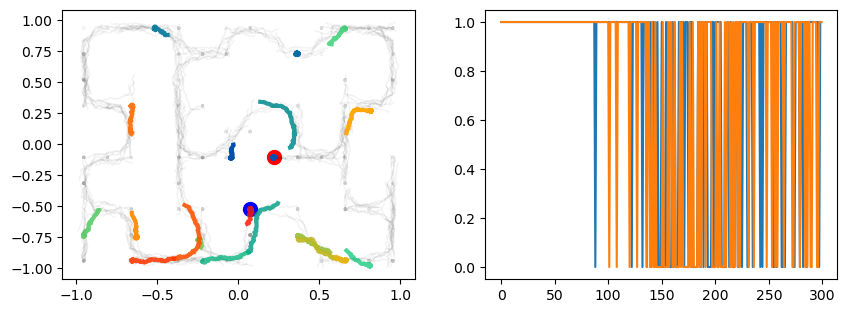

  7%|▋         | 4999/75000 [04:17<1:00:15, 19.36it/s]

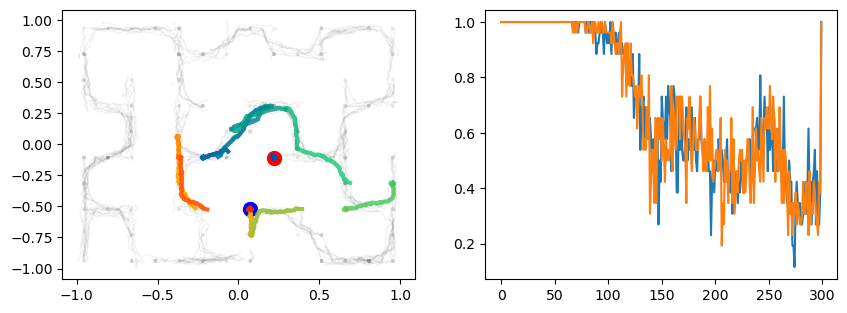

 13%|█▎        | 9999/75000 [08:38<59:13, 18.29it/s]  

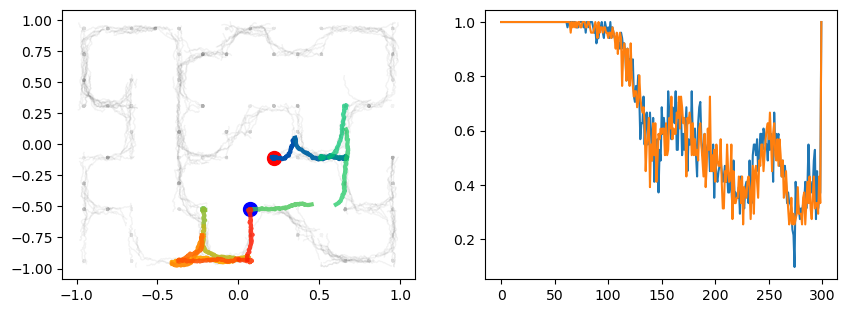

 20%|█▉        | 14999/75000 [13:11<53:50, 18.57it/s]  

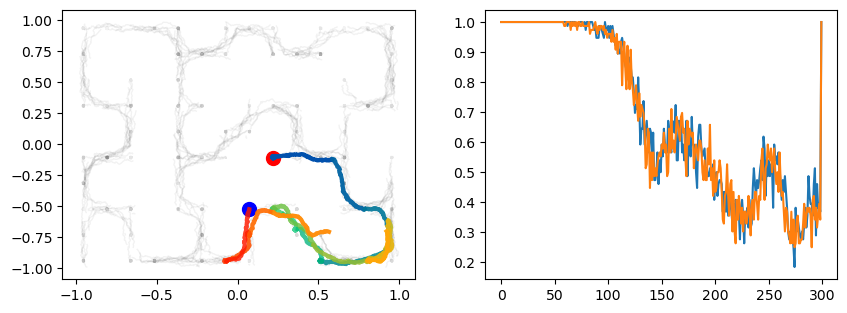

 27%|██▋       | 20000/75000 [17:38<46:01, 19.92it/s]  

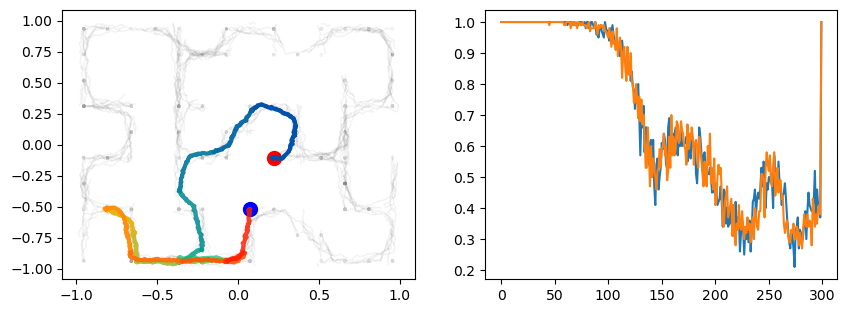

 33%|███▎      | 25000/75000 [22:03<44:45, 18.62it/s]  

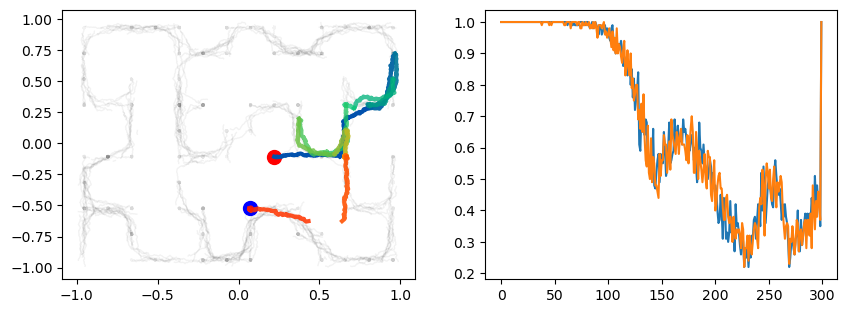

 40%|████      | 30000/75000 [26:35<40:40, 18.44it/s]  

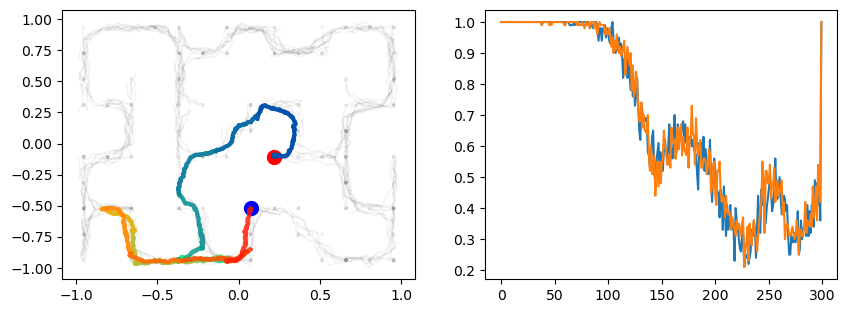

 47%|████▋     | 34999/75000 [31:00<34:13, 19.48it/s]  

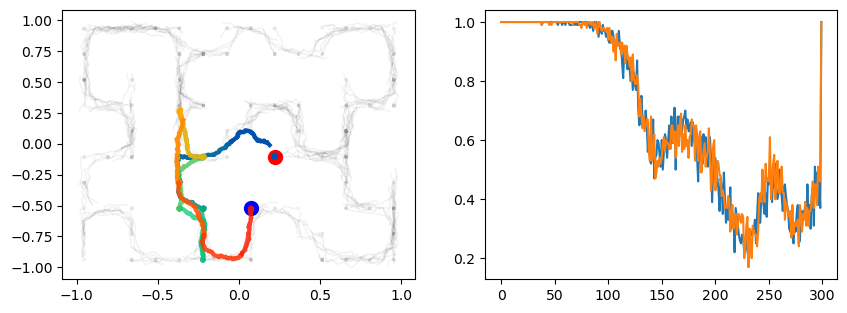

 53%|█████▎    | 39999/75000 [35:49<38:40, 15.09it/s]  

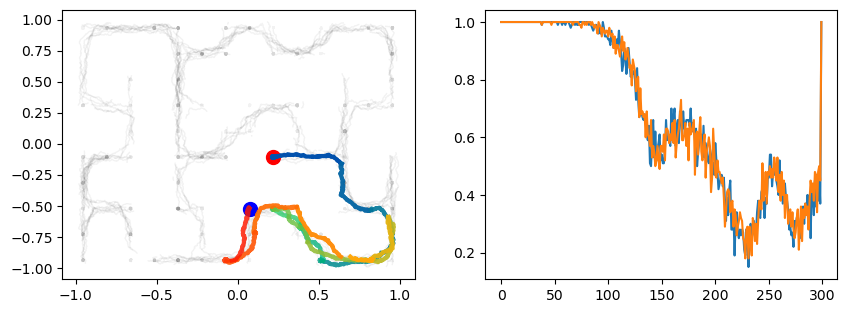

 60%|██████    | 45000/75000 [40:08<25:00, 19.99it/s]  

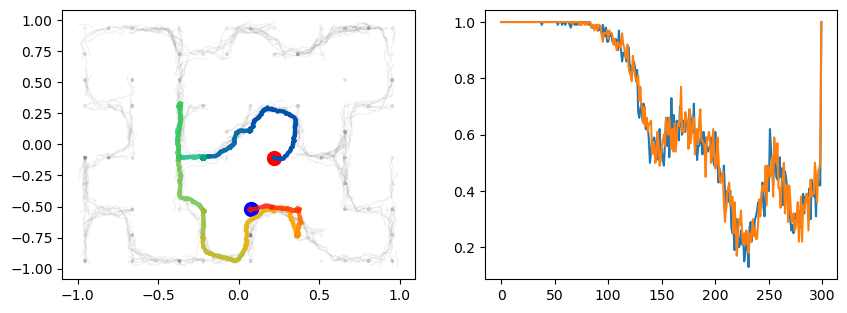

 67%|██████▋   | 50000/75000 [44:48<25:16, 16.49it/s]  

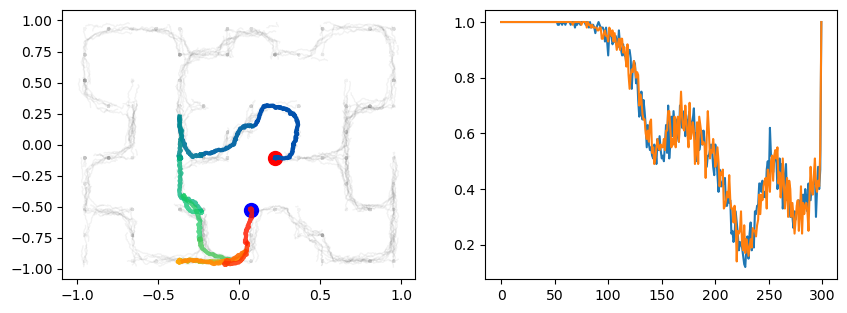

 73%|███████▎  | 55000/75000 [49:50<19:55, 16.73it/s]  

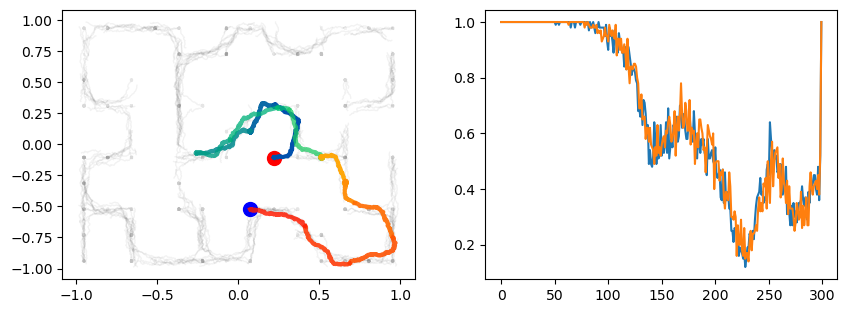

 80%|███████▉  | 59998/75000 [54:21<12:29, 20.00it/s]  

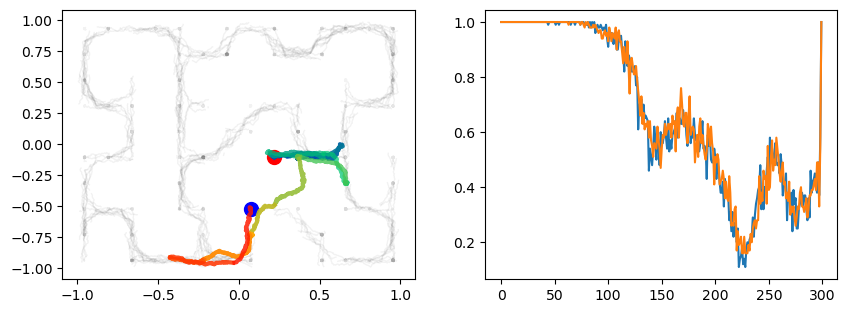

 87%|████████▋ | 64999/75000 [58:31<08:10, 20.38it/s]

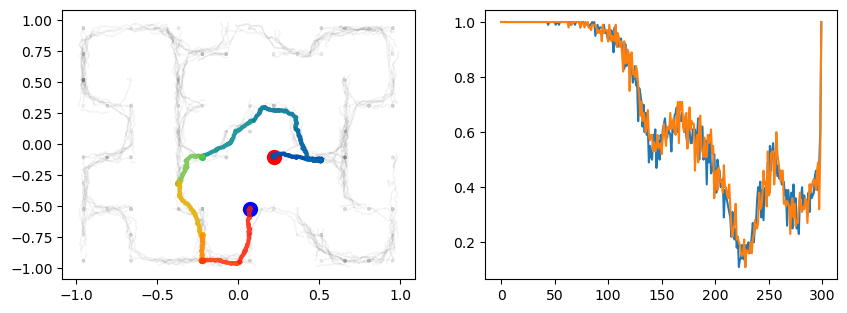

 93%|█████████▎| 69999/75000 [1:02:52<04:51, 17.17it/s]

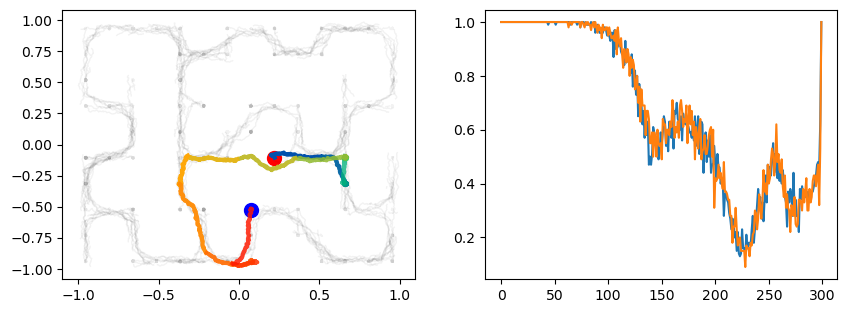

100%|██████████| 75000/75000 [1:07:36<00:00, 18.49it/s]


In [18]:
for iter in tqdm(range(75000)): # 150000 PT iterations
    with torch.no_grad():
        all_samples, MASKS1, MASKS2, NEW_SAMPLES = APT_control(n_trajs, 
                                                               path_length,
                                                               model_traj=ema_net,
                                                               Samples=Samples, 
                                                               step_size=step_size, 
                                                               gap=gap)
        if iter % 200 == 0: # save the samples and masks every 200 iterations
            ALL_SAMPLES += all_samples
            MASK1 += MASKS1
            MASK2 += MASKS2
        Samples = NEW_SAMPLES

        if iter % 5000 == 0:
            plt.figure(figsize=(10, 3.5))
            plt.subplot(1, 2, 1)
            x = trajs[torch.randint(0, trajs.shape[0], (500,))].reshape(-1, 64, 2)
            for i in range(x.shape[0]):
                plt.plot(x[i, :, 0].cpu().detach(), x[i, :, 1].cpu().detach(), color='black' , alpha=0.05, linewidth=1)
            # plot A and 
            plt.scatter(A[0].cpu(), A[1].cpu(), s=100, c='r')
            plt.scatter(B[0].cpu(), B[1].cpu(), s=100, c='b')


            s = Samples[-1][-1].reshape(-1, n_trajs, path_length, 2)[0]
            
            # Create colormap from yellow to red
            from matplotlib.colors import LinearSegmentedColormap
            cmap = LinearSegmentedColormap.from_list("yellow_red", ["yellow", "red"])
            cmap = LinearSegmentedColormap.from_list(
                "blue_green_orange",
                ["#0151AD", "#00CC6DB3", "#FFB108", "#FF0000CF"]  # bright blue → vivid green → warm orange
            )
            # Normalize for values 1–20
            norm = plt.Normalize(vmin=1, vmax=n_trajs)
            for i in range(s.shape[0]):
                plt.plot(s[i, :, 0].cpu().detach(), s[i, :, 1].cpu().detach(), color=cmap(norm(i)), linewidth=3)

            plt.subplot(1, 2, 2)
            plt.plot(torch.stack(MASK1[-100:]).float().mean(0).cpu().numpy())
            plt.plot(torch.stack(MASK2[-100:]).float().mean(0).cpu().numpy())
            plt.show()

            ALL_sub_samples = [i[::50] for i in ALL_SAMPLES] # thinned samples for saving memory
            ALL_sub_samples = torch.stack(ALL_sub_samples)
            # save ALL_SAMPLES (thinned)
            torch.save(ALL_sub_samples, f'official_task_{task_id}.pt')

In [20]:
ALL_sub_samples = [i[::50] for i in ALL_SAMPLES]
ALL_sub_samples = torch.stack(ALL_sub_samples)
# save ALL_SAMPLES
torch.save(ALL_sub_samples, f'official_task_{task_id}.pt')